# Broadband Growth Across the US
## Data Storytelling
### Chester Hitz | Springboard Data Science Career Track | Capstone I

The goal of this section of my capstone project is to analyze the data I wrangled in the previous step and seek out trends. The primary dataset I'll be examining is the Broadband Subscription Category, the rate of broadband in each county, divided across five years in the data. I start with the standard importation of libraries and data.

In [3]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

# import relevant data
broadband = pd.read_csv('broadband.csv', dtype={'county_fips':str})

# this fixes an issue in the data where employment was showing up as total number of
# workers despite calling the correct variable from the census API.
broadband['EmploymentRate'] = broadband['EmploymentRate'] / broadband['Population']

----------------------------------
### Target Variable

The target variable here is the category of broadband subscription category (BSC). The categories are listed as follows, with x representing connections per 1,000 households:

* 0: Zero 
* 1: Zero < x <= 200 
* 2: 200 < x <= 400 
* 3: 400 < x <= 600 
* 4: 600 < x <= 800 
* 5: 800 < x

The target data has been broken down by year with various factors added. A good way to initially visualize the target data is through the use of a joyplot, which shows KDE plots for each year.

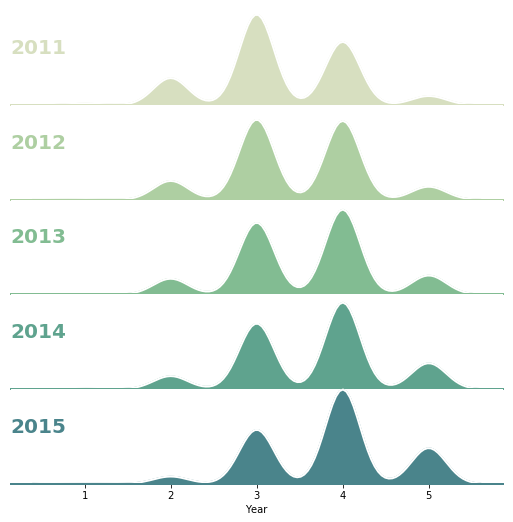

In [4]:
# simplifying dataframe
jp_df = broadband[['Year', 'BSC']]

# Initialize the FacetGrid object. Note: this code modified from seaborn documentation
pal = sns.cubehelix_palette(8, start=.5, rot=-.75)
g = sns.FacetGrid(jp_df, row="Year", hue="Year", aspect=5, size=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "BSC", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "BSC", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(jp_df, color, label):
    ax = plt.gca()
    ax.text(0, .6, label, fontweight="bold", fontsize = 20, color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Year")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

Though it is subtle, we can see a gradual movement of values to the right towards higher BSC values over time. The frequency of category 3 falls over time, while more counties move into the top category, 5. However, category 4 is the clearly most dominant each year except for 2011. We can also show this numerically:

In [5]:
print(jp_df.groupby('Year').describe())

         BSC                                             
       count      mean       std  min  25%  50%  75%  max
Year                                                     
2011  3139.0  3.267920  0.787830  1.0  3.0  3.0  4.0  5.0
2012  3139.0  3.442179  0.774896  1.0  3.0  3.0  4.0  5.0
2013  3139.0  3.555272  0.786510  1.0  3.0  4.0  4.0  5.0
2014  3139.0  3.648933  0.806112  1.0  3.0  4.0  4.0  5.0
2015  3138.0  3.824410  0.775841  1.0  3.0  4.0  4.0  5.0


Observations:
* The mean is moving fairly steadily upwards by about .1 each year.
* The median switched in 2013 from 3 to 4.
* The standard deviation does not change significantly between years.

### Urban vs Rural

A further interesting way of examing our data is by classifying it into different categories, and the rural percentage factor provides an interesting means of doing this. As detailed <a href=' https://www2.census.gov/geo/pdfs/reference/ua/Defining_Rural.pdf'>here </a>, the counties are classified as:

*  100%: Completely rural
*  50-99.9%: Semi-rural
*  0 - 50%: Urban

Applying a quick classification function allows more interesting visualizations and clearer trends.

In [6]:
def UR_classifier(row):
    rural = row['Rural_Pct']
    if rural == 100: return 'Completely Rural'
    elif rural >= 50: return 'Semirural'
    else: return 'Urban'
    
broadband['UR_class'] = broadband.apply(UR_classifier, axis=1)
broadband['UR_class'].astype('category')
broadband['UR_class'].value_counts()

Urban               6285
Semirural           5905
Completely Rural    3504
Name: UR_class, dtype: int64

Keep in mind those numbers are for all counties in the US multiplied by the number of years, so that is why the numbers appear so high. We can now examine how BSC interacts with these three categories. The first way of doing this is through a bar-plot comparing the average BSC for each category over time.

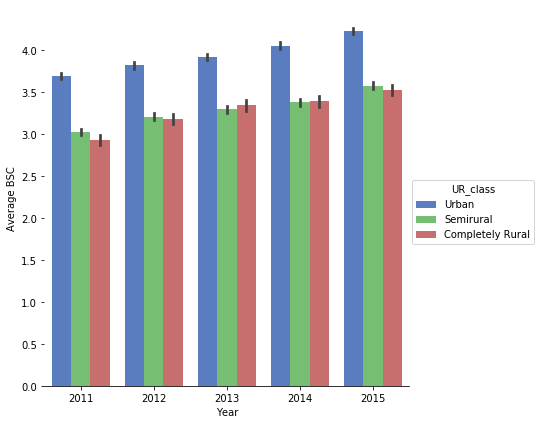

In [7]:
g = sns.factorplot(x="Year", y="BSC", hue="UR_class", data=broadband,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Year", "Average BSC")
plt.show()

Unsurprisingly, urban leads each year as might be expected from earlier findings. Surprisingly, there is little difference between rural and semirural counties when it comes to BSC. 

For the next step, I put BSC for a moment to explore how the urban/rural classification interacts with other variables. For example, the scatterplots below shows how rural, semi-rural, and urban counties differentiate themselves on with four different economic factors:

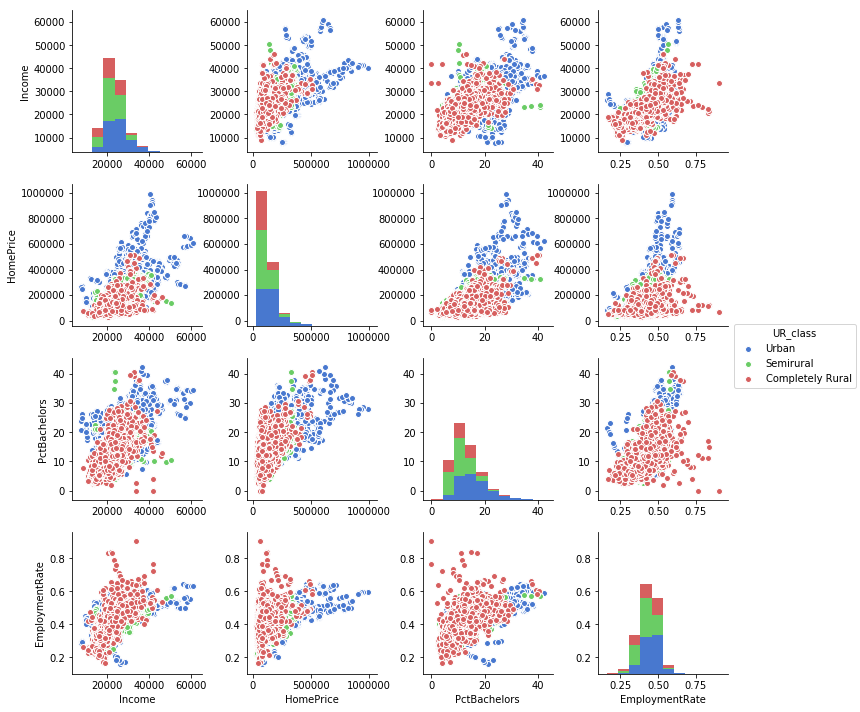

In [9]:
pair_df = broadband[['Income', 'HomePrice', 'PctBachelors', 'EmploymentRate', 'UR_class']]
pair_df = pair_df.dropna()

sns.pairplot(pair_df, hue="UR_class", palette="muted")
plt.show()

This graph is loaded with interesting information. It is quite clear that on the whole, rural and semirural counties lag behind urban counties in terms of educational attainment, income and home price. From the bar plot created earlier, I saw that urban counties lead in terms of BSC which leads me to suspect that economic factors are closely correlated with BSC. I will test this in the Inferential Statistics step of my capstone.

-------------------------------
### Mapping

Since each row in this dataset represents a different geographical area, it only makes sense to create a map displaying some of the data. The maps below were created in QGIS with shapefiles downloaded from the Census Bureau. They display the total change in BSC for each county between 2011 and 2015.

In [10]:
map_df = broadband[['BSC', 'Year', 'county_fips', 'Population']]
map_df = map_df.pivot(index='county_fips', columns='Year')
map_df['BSC_change'] = map_df['BSC'][2015] - map_df['BSC'][2011]
map_df.to_csv('map_data.csv')

![SF Bay Area](Mapping/BayArea.png)
<center> **SF Bay Area** </center>


![Texas](Mapping/Texas.png)
<center>  **Texas** </center>

![Eastern Seaboard](Mapping/EasternSeaboard.png)
<center> **East Coast** </center>

These maps aren't conclusive on their own necessairily, but open up some interesting avenues in terms of exploring correlation via spatial means.

## Conclusions

This small step in my project has been an important link between my initial data collection and my upcoming inferential analysis. In that next step, I build on the findings here to test whether economic factors are the most closely correlated with BSC, as well as explore some geographical interpolation methods.